# ECS7024 Statistics for Artificial Intelligence and Data Science

## Georgia Gunson

## Aims and Outline

The overall aim of this notebook is to understand more about changes in property prices across regions of the UK.

 1. Section 1: Load and prepare the data
     1. Introducing the data
     1. Missing data
     1. Handling date time data
 1. Section 2: Identifying trends
     1. Price over time
     1. Price, region and property type
     1. Price by region over time
 1. Section 3: Price changes
     1. Calculate price changes
     1. Explore differences 
 1. Section 4: Statistical analysis


In [1]:
# Load packages
import pandas as pd
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1: Load and prepare the data

In [2]:
# Read in the data
average_property_price = pd.read_csv('average-property-price.csv')
location_codes = pd.read_csv('location-codes.csv')

### Introducing the data

The dataset used in this report is of the average price of properties over 36 months, from September 2016 to September 2019 in different areas of the UK. There are four different types of property listed: 'Detached', 'Semi', 'Terraced' and 'Flat'. Our analysis will focus on 'Detached' and 'Flat' data to identify patterns in property prices across regions, time and property type. 

The geographic information for each area has been sourced from the Office for National Statistics (ONS). There are two different area levels explored in this report, regions and local government area, as defined by the UK goverment system. In our analysis, the term 'Area' will refer to the local goverment area, which are parts of a given region. 

In [3]:
# Separate the region data (with ‘E12’ prefix codes) from the area data (other prefixes). 
average_property_price_region = average_property_price.loc[average_property_price['Code'].str.startswith('E12')].copy()
average_property_price_area = average_property_price.loc[~ average_property_price['Code'].str.startswith('E12')].copy()

In [4]:
# Join area and location data to get the region information
# Do not remove any columns for now as some AuthorityNames are different to the area name
average_property_price_area = pd.merge(average_property_price_area, location_codes, how='left', left_on='Code', right_on='AuthorityCode')

### Missing data

When investigating if the distribution of missing data is balanced across areas, we observe that the missing values are exclusively in the area of the City of London for 'Detached', 'Semi' detached and 'Terraced' properties. This may not be due to error as it is possible that properties of that type do not exist in the part of London sampled. This assumption is supported by the absence of any 'Detached' or 'Semi' data for that area, as seen in Table 2. As this may not be due to error, I will not remove or replace the missing data for 'Detached' or 'Semi' detached property types.

**Table 1.** The percentage of missing values in each column of `average_property_price_area`, rounded to 2 decimal places

In [27]:
# Evaluate the percentage of missing data to inform strategy
round(100*(average_property_price_area.isnull().sum())/len(average_property_price_area),2)

Date             0.00
Area             0.00
Code             0.00
Detached         0.66
Semi             0.66
Terraced         0.37
Flat             0.00
AuthorityCode    0.00
AuthorityName    0.00
RegionCode       0.00
RegionName       0.00
Month_Year       0.00
Year             0.00
Quarter          0.00
dtype: float64

In [6]:
# Find the areas that have missing values
print('The areas containing missing data:',average_property_price_area.loc[pd.isnull(average_property_price_area['Semi']), 'Area'].unique() )

The areas containing missing data: ['City of London']


**Table 2.** The percentage of missing values for the 'City of London' data, from the table `average_property_price_area`, rounded to 2 decimal places

In [28]:
# What percentage of the 'City of London' data is missing?
round(100*(average_property_price_area.loc[average_property_price_area['Area'] == 'City of London'].isnull().sum())/len(average_property_price_area.loc[average_property_price_area['Area'] == 'City of London', 'Semi']),2)

Date               0.00
Area               0.00
Code               0.00
Detached         100.00
Semi             100.00
Terraced          55.56
Flat               0.00
AuthorityCode      0.00
AuthorityName      0.00
RegionCode         0.00
RegionName         0.00
Month_Year         0.00
Year               0.00
Quarter            0.00
dtype: float64

There is missing data from 2018 onwards for 'Terraced' housing in the 'City of London' area, Table 3. Again, this may be due to the area sampled rather than error. While the 'City of London' cannot be compared to other areas for 'Terraced' properites after 2018, 'Flat' data for this area will remain in downstream analysis.

**Table 3.** The date range of missing values for the 'City of London' data on 'Terraced properties, from the table average_property_price_area

In [8]:
average_property_price_area.loc[average_property_price_area['Terraced'].isnull()==True, 'Date']

3292    01/01/2018
3293    01/02/2018
3294    01/03/2018
3295    01/04/2018
3296    01/05/2018
3297    01/06/2018
3298    01/07/2018
3299    01/08/2018
3300    01/09/2018
3301    01/10/2018
3302    01/11/2018
3303    01/12/2018
3304    01/01/2019
3305    01/02/2019
3306    01/03/2019
3307    01/04/2019
3308    01/05/2019
3309    01/06/2019
3310    01/07/2019
3311    01/08/2019
Name: Date, dtype: object

In [9]:
# Evaluate the percentage of missing data to inform strategy
print('There are', average_property_price_region.isnull().sum().sum(), 'missing data for the regional table')

There are 0 missing data for the regional table


### Handling date time data

In [10]:
# Adding different time frequencies to the regional and area data

# Region data
# Add month/year column 
average_property_price_region['Month_Year'] = pd.to_datetime(average_property_price_region['Date'], format='%d/%m/%Y')
# add separate year column
average_property_price_region['Year'] = pd.to_datetime(average_property_price_region['Date']).dt.year
# add quarter
average_property_price_region['Quarter'] = average_property_price_region['Month_Year'].dt.quarter

# Seems to still be a string so requires conversion to date time after creation??
average_property_price_region['Month_Year'] = pd.to_datetime(average_property_price_region['Month_Year'], format='%m/%Y')
average_property_price_region['Year'] = pd.to_datetime(average_property_price_region['Year'], format='%Y')
average_property_price_region['Date'] = pd.to_datetime(average_property_price_region['Date'], format='%d/%m/%Y')

# Area data
# Add month/year column 
average_property_price_area['Month_Year'] = pd.to_datetime(average_property_price_area['Date'], format='%d/%m/%Y')
# add separate year column
average_property_price_area['Year'] = pd.to_datetime(average_property_price_area['Date']).dt.year
# add quarter
average_property_price_area['Quarter'] = average_property_price_area['Month_Year'].dt.quarter

# Seems to still be a string so requires conversion to date time after creation??
average_property_price_area['Month_Year'] = pd.to_datetime(average_property_price_area['Month_Year'], format='%m/%Y')
average_property_price_area['Year'] = pd.to_datetime(average_property_price_area['Year'], format='%Y')


## Part 2: Identifying trends

Following data preparation, we will explore and identify trends in the price of flat and detatched property types across the 9 regions of our dataset.

In [11]:
# Remove excess columns
region_price_trend = average_property_price_region.drop(columns=['Semi', 'Terraced']).copy()

### Price over time

In Figure 1., the median of the average flat and detached property prices for all regions exhibit an increase between September 2016 and September 2019. The data was aggregated to median values to account for any possible outliers or skewed distribution of the data. There appear to be two declines in detached and flat property prices in Q2 of 2018 and 2019 respectively. However, property prices continued to increased after both troughs. No direct trend was observed between time of the year, evaluated by quarter, and flat or detached property prices, seen in Figure 2.

In [12]:
# Set the index as the month in order to resample for quarterly interval
region_price_trend.set_index('Month_Year',inplace=True)
# resample with the mean per each quarter
resample_region_trend = region_price_trend.resample('Q').median()

**Figure 1.** The median flat and detached average property price per quarter over each year. Flat prices are represented in blue, detached prices in orange. It is important to note that the Y axis range of both plots are specific to each property type in order to visualise each trend. 

C:\Users\georg\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


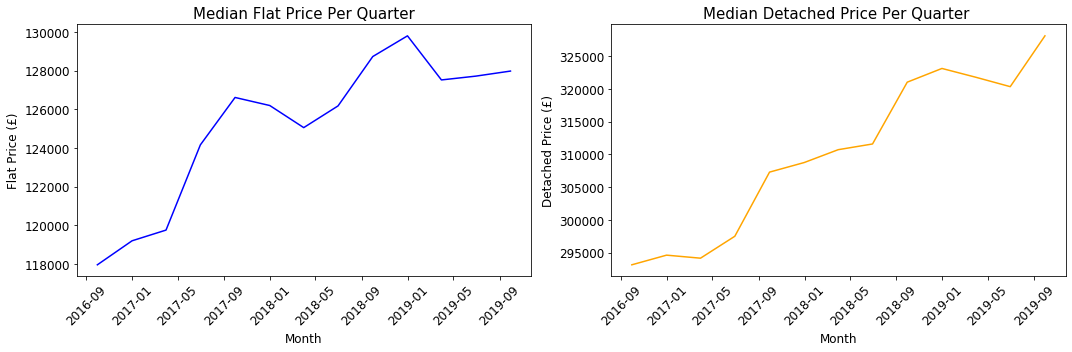

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)

# Flat prices per quarter
sns.lineplot(ax=axes[0], x='Month_Year', y='Flat', data=resample_region_trend.reset_index(), color='blue')
axes[0].set_title('Median Flat Price Per Quarter', fontsize=15)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Flat Price (£)',fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Detached prices per quarter
sns.lineplot(ax=axes[1], x='Month_Year', y='Detached', data=resample_region_trend.reset_index(), color='orange')
axes[1].set_title('Median Detached Price Per Quarter ', fontsize=15)
axes[1].set_xlabel('Month',fontsize=12)
axes[1].set_ylabel('Detached Price (£)',fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
                    
plt.tight_layout()
plt.show()


**Figure 2.** Flat and detached property prices grouped by quarter, across all 9 regions and 36 months in the data. The solid lines represent the mean of the prices per quarter, with the tranparent areas indicating the spread of the data around the mean. This plot provides a visual of any possible trends in property price with the time of year between 2016 and 2019.

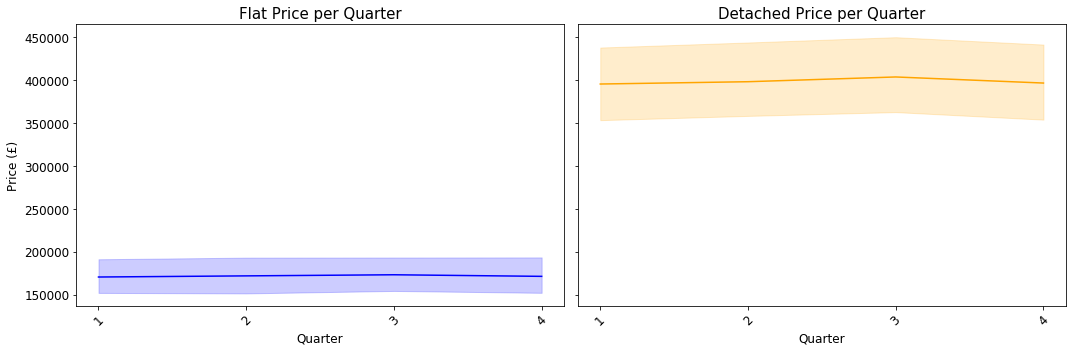

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Flat prices per quarter
sns.lineplot(ax=axes[0], x='Quarter', y='Flat', data=region_price_trend, color='blue')
axes[0].set_title('Flat Price per Quarter', fontsize=15)
axes[0].set_xlabel('Quarter', fontsize=12)
axes[0].set_ylabel('Price (£)',fontsize=12)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_xticks([1,2,3,4])

# Detached prices per quarter
sns.lineplot(ax=axes[1], x='Quarter', y='Detached', data=region_price_trend, color='orange')
axes[1].set_title('Detached Price per Quarter', fontsize=15)
axes[1].set_xlabel('Quarter',fontsize=12)
axes[1].set_ylabel('Price (£)',fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_xticks([1,2,3,4])
                    
plt.tight_layout()
plt.show()


### Price, region and property type

Detached properties appear to be consistently more expensive than flats across all regions and months, as seen in the data of Figure 3. London observes a much higher average price for both property types than all other regions. The South East, East of England and South West exhibit higher average prices for flats and detatched properties than all other regions outside of London. Regions with average detached property prices < £300,000 also appear to have a narrower difference in price between the flat and detached property types than more expensive regions.

**Figure 3.** Distribution of detached and flat property prices across each region. A point represents an average property price for a region in a given month, with orange indicating detached properties and blue representing flats. 

In [15]:
# To plot both flat and detached values on same plot
# Add property type column specifying which value
# pivot from wide to narrow with all values in one column
region_price_by_property =pd.melt(region_price_trend[['Area','Detached','Flat']].reset_index(), id_vars=['Area', 'Month_Year'], var_name='PropertyType', value_name='Price')

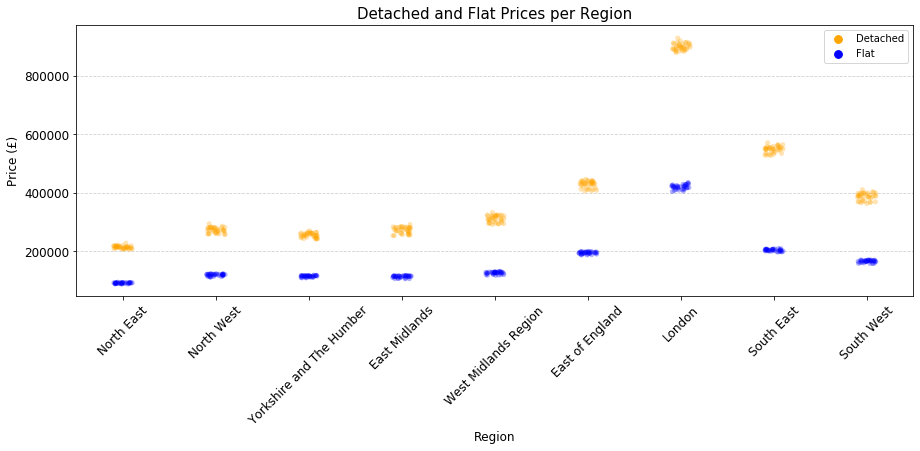

In [16]:
plt.figure(figsize=(15, 5))

# Side-by-side bar plot
sns.stripplot(x='Area', y='Price', hue='PropertyType', data=region_price_by_property,  palette=["orange","blue"],
             alpha=0.3)

plt.title('Detached and Flat Prices per Region', fontsize=15)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Price (£)', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.gca().yaxis.grid(True, linestyle='--', alpha=0.6)

plt.show()


### Price by region over time

To aid visualisation of patterns in the average prices of property for each region over time, data for London was isolated due to its extreme values which distort the range of the property prices on the plots, compressing the values for the other regions. 


In Figure 4, you can see four lineplots representing the average flat and detached property prices over time by region. The top two plots contain data for all regions except London. The bottom two plots contain data for London properties only. Ostensibly, the average flat price appears to fluctuate each year within a £20,000 interval for each region, not including London. The hierarchy of average regional flat prices remains constant for all regions except the 'East Midlands' and 'Yorkshire and The Humber' which overlap mulitple times from 2018 to 2019. All regional flat prices experienced small peaked increases in average flat price in Q1 of 2017 before a more consistent period of flat price increases to September 2017. There appear to be two notable decreases in flat price universal to regions between Q1 and Q2 of 2018 as well as between Q1 and Q2 of 2019. 

For the London line plots, it is important to note that the interval of the 'Price (£)' on the y-axis is a £30,000 range while for the other regions, this is a £100,000 range. You can observe the price peaks and troughs in finer detail on the London plot, however the magnitude of price changes appears comparable in London to the other regions. 

The average price of detached properties exhibits a positive trend over time for all regions, increasing with fluctuations from September 2016 to September 2019. The hierarchy of detached property price remains consistent for all regions except the 'North West' and 'East Midlands' which overlap and have almost indistinguishable inter regional differences over time. Observing the data for London, you are able to see increases in price between Q3 and Q4 of 2017 and Q3 and Q4 of 2018. The most notable price decrease occurs in Q1 of 2019. These patterns are also observed across all other regions in the top-left line plot, however, due to the difference in scale on the y-axis, they appear more subtle. When interpreting the results of the detached property subplots, take care to consider the difference in y-axis range intervals.


**Figure 4.** Average flat and detached property prices over time by region. London data was isolated due to its extreme values which distort the range of the property prices on the plots. The top two plots depict the trend of average flat and detached property prices over successive months for regions outside London. The bottom two plots contain this data but for the region of London alone. When interpreting the results of the detached property subplots, take care to consider the difference in y-axis range intervals.

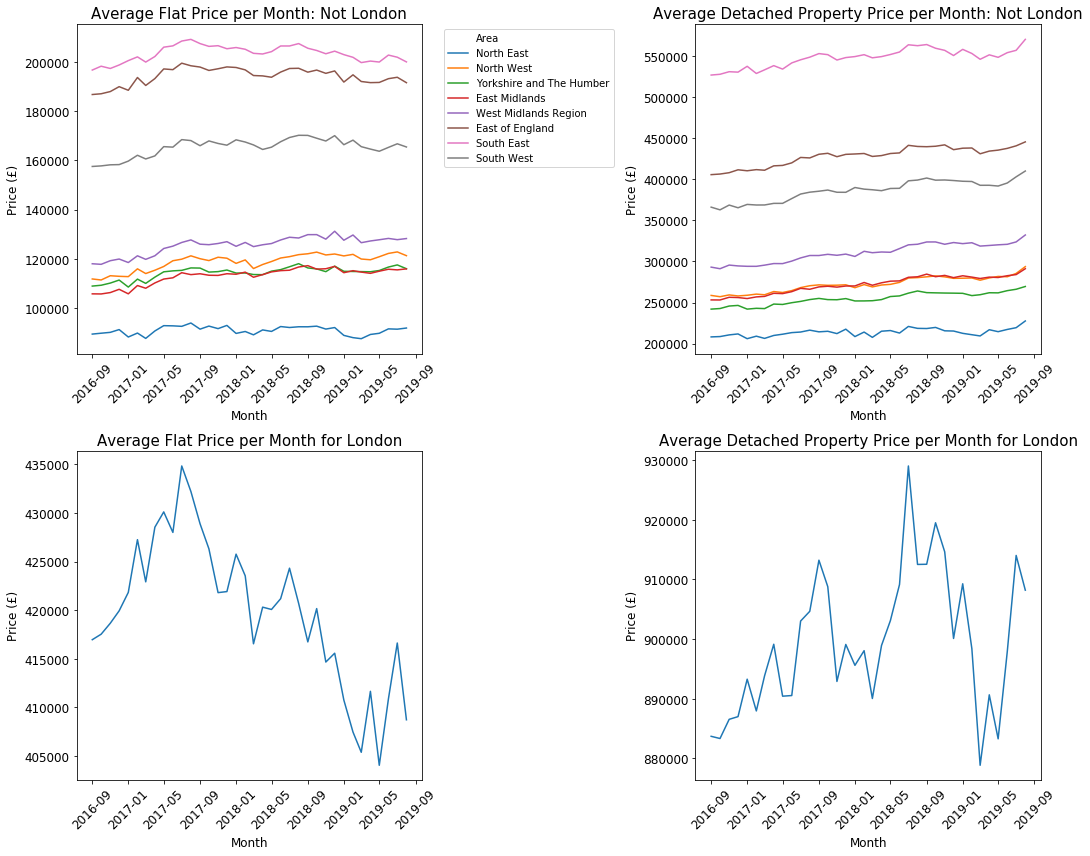

In [17]:
# Plot prices over time by each region 
# Separate London and other regions due to large difference
# Easier to identify trends

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Remove London from data
not_london_data = region_price_trend[region_price_trend['Area'] != 'London']


# Flat prices for all areas
sns.lineplot(ax=axes[0, 0], x='Date', y='Flat', hue='Area', data=not_london_data)
axes[0, 0].set_title('Average Flat Price per Month: Not London', fontsize=15)
axes[0, 0].set_xlabel('Month', fontsize=12)
axes[0, 0].set_ylabel('Price (£)', fontsize=12)
axes[0, 0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0, 0].tick_params(axis='y', labelsize=12)
axes[0, 0].legend( bbox_to_anchor=(1.05, 1), loc='upper left')


# Detached prices for all areas
sns.lineplot(ax=axes[0, 1], x='Date', y='Detached', hue='Area', data=not_london_data, legend=False)
axes[0, 1].set_title('Average Detached Property Price per Month: Not London', fontsize=15)
axes[0, 1].set_xlabel('Month', fontsize=12)
axes[0, 1].set_ylabel('Price (£)', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=45, labelsize=12)
axes[0, 1].tick_params(axis='y', labelsize=12)


# Select for London
london_data = region_price_trend[region_price_trend['Area'] == 'London']

# Flat prices for London
sns.lineplot(ax=axes[1, 0], x='Date', y='Flat', data=london_data)
axes[1, 0].set_title('Average Flat Price per Month for London', fontsize=15)
axes[1, 0].set_xlabel('Month', fontsize=12)
axes[1, 0].set_ylabel('Price (£)', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=12)
axes[1, 0].tick_params(axis='y', labelsize=12)


# Detached prices for London
sns.lineplot(ax=axes[1, 1], x='Date', y='Detached', data=london_data)
axes[1, 1].set_title('Average Detached Property Price per Month for London', fontsize=15)
axes[1, 1].set_xlabel('Month', fontsize=12)
axes[1, 1].set_ylabel('Price (£)', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1, 1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()


## Part 3: Price Changes

Here, we evaluate how the price of flats change over time by calculating the change in the average price of flats per area between July 2017 and July 2018.

### Calculate price changes

In [18]:
# Subset data for months of interest (July 2017 - July 2018)
area_flat_price_2017 = average_property_price_area[(average_property_price_area['Month_Year'] == '2017-07-01')].copy()
area_flat_price_2018 = average_property_price_area[(average_property_price_area['Month_Year'] == '2018-07-01')].copy()

In [19]:
# Drop excess columns
area_flat_price_2017 = area_flat_price_2017.drop(columns=['Detached', 'Semi', 'Terraced'])
area_flat_price_2018 = area_flat_price_2018.drop(columns=['Detached', 'Semi', 'Terraced'])

In [20]:
# Join tables using area code (can later use to get location info)
area_flat_price_change = pd.merge(area_flat_price_2017[['Code', 'Flat']], area_flat_price_2018[['Code', 'Flat']], on='Code', suffixes=('_2017', '_2018'))

# Calculate the difference
area_flat_price_change['Price_Difference'] = area_flat_price_change['Flat_2017'] - area_flat_price_change['Flat_2018']

# Add the location data back 
area_flat_price_change = pd.merge(area_flat_price_change, location_codes, how='left', left_on='Code', right_on='AuthorityCode')

In [21]:
# Order by price difference
area_flat_price_change_sorted = area_flat_price_change.sort_values(by='Price_Difference', ascending=True)

### Explore differences 

**Table 4.** Summary statistics of the difference in average flat price between July 2017 and July 2018, rounded to 2 decimal places (2.d.p).

In [22]:
area_flat_price_change['Price_Difference'].describe().round(2)

count      151.00
mean      2217.20
std      10373.63
min     -17836.14
25%      -1934.92
50%         70.57
75%       2297.15
max      90900.29
Name: Price_Difference, dtype: float64

In Table 4 are summary statistics for the differences in average flat price across all areas between July 2017 and July 2018. There is a large range in price differences from a decrease of £17836.14 (2.d.p) to an increase of £90900.29 (2.d.p). A much smaller interquartile range than full range of £-1934.92 to £2297.15 in combination with a mean (£2217.20) much larger than the median (£70.57) indicates that the data is very positively skewed. The majority of the data lies within a price decrease of approximately £2000 and an increase of approximately £2300, however there are more extreme price increases causing this positive skew. This can be observed in Figure 5; the region of London has a wide spread of price differences across the areas it encompasses. As a large capitol city with a diverse range of neighbourhoods, it is not unexpected that some areas experienced a sizeable decrease in average flat price while others observed large increases. Comparatively, the data for other regions is much more clustered around y=0 with only the 'South East' and the 'East of England' observing notable increases in the average flat price during this time. However, all regions contain areas that recorded decreases in flat price. The 'North West', 'South West', 'East Midlands' and 'West Midlands' all appear to have a high proportion of the areas they contain report decreases in average flat price. This is further supported in Figure 6 which displays the median and interquartile range (IQR) of the changes in average flat price per each region between July 2017 and July 2018. For the 'East Midlands','East of England', 'South West', 'West Midlands' and 'Yorkshire and The Humber' the regional median price difference is negative, reflecting decreases in flat prices in areas across each region. The largest declines in median differences per region are observed in the Midlands. London, despite recording the largest decreases in average flat price, has a median difference that is much greater than other regions. It is important to note that the spread of the data in this figure is different to that of Figure 5. due to the removal of outliers per region by the computational method of plotting. 

In summary, London flat prices have a much larger spread of price changes from July 2018 to July 2018 than other regions of the UK. This may be explained by the diversity of areas and its position as a Capitol city. All regions contained areas that observed decreases in flat prices during this time. The Midland regions both had a large proportion of areas report decreases in flat price and consequently had notable negative average changes in flat price in this period. The South East observed the second largest mean change in average flat price across its areas, followed by the East of England. 


**Figure 5.** The distribution of price differences for each area by region. Each data point is the difference in average flat price between July 2017 and July 2018 for an area in a given region.  The horizontal black line is a price difference of 0.

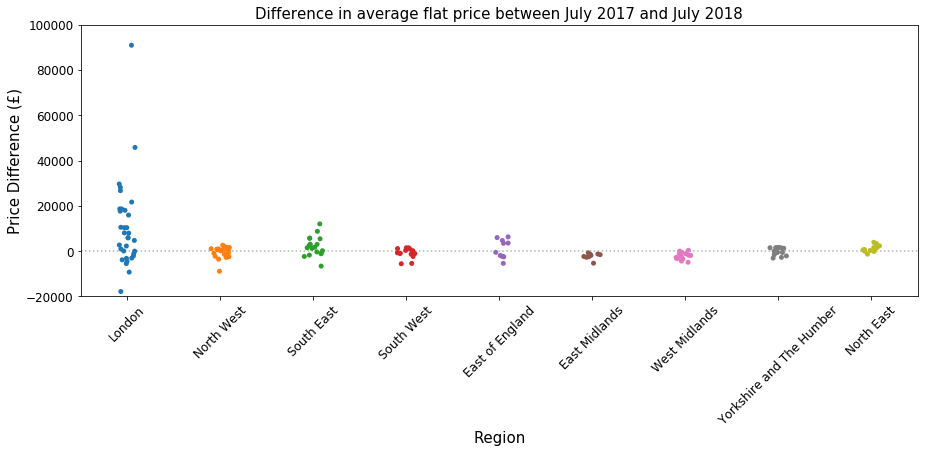

In [23]:
# PLot each area value but within each Region category, strip plot seems to do this
# Create a strip plot
plt.figure(figsize=(15, 5))
sns.stripplot(x='RegionName', y='Price_Difference', data=area_flat_price_change_sorted,
              jitter=True, palette="tab10", dodge=True)

plt.title('Difference in average flat price between July 2017 and July 2018', fontsize=15)
plt.xlabel('Region', fontsize=15)
plt.ylabel('Price Difference (£)', fontsize=15)
plt.ylim(-20000, 100000)


# fiddle with aesthetics
plt.xticks(rotation=45, fontsize=12)
plt.yticks( fontsize=12)
# 0 line for increase or decrease visual
plt.axhline(y=0, color='black', linestyle='dotted', alpha=0.3)

# Show the plot
plt.show()


**Figure 6.** The median and interquartile range (IQR) of the differences in average flat price for areas within each region between July 2017 and July 2018. Each box corresponds to a specifc region. The cental line in each box is the median value, while the top and bottom of each box represent the IQR. The whiskers extend to the minimum and maximum values, highlighting the range of price differences. Outliers are not shown on this plot for better clarity across all regions. The horizontal red line is a price difference of 0.

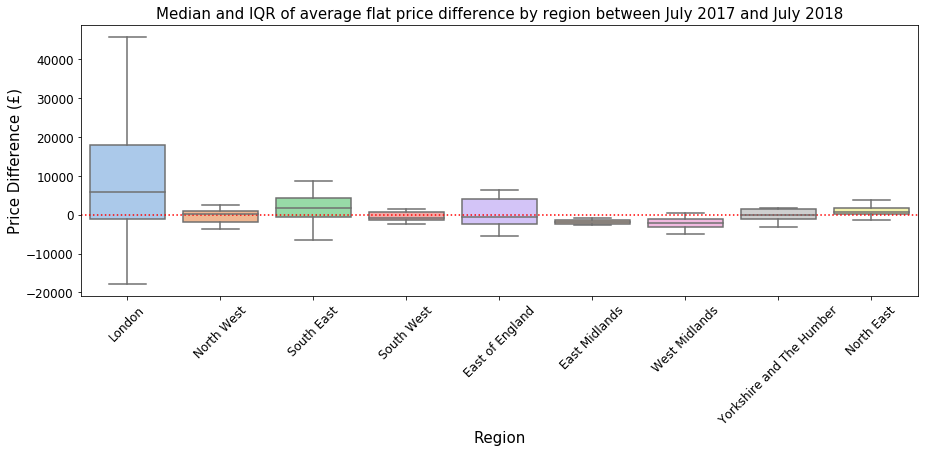

In [24]:
plt.figure(figsize=(15, 5))

# Median and interquartile range visual
sns.boxplot(x='RegionName', y='Price_Difference', data=area_flat_price_change_sorted, showfliers=False, palette='pastel')

plt.xticks(rotation=45) 
plt.title('Median and IQR of average flat price difference by region between July 2017 and July 2018', fontsize=15)
plt.xlabel('Region', fontsize=15)
plt.ylabel('Price Difference (£)', fontsize=15)
# 0 line for increase or decrease visual
plt.axhline(y=0, color='red', linestyle='dotted')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.show()


## Part 4: Statistical analysis

In this final section, we will use statistical analysis to investigate whether there is evidence that the change in the average price of flats has affected all regions uniformly or varies by region. To do so, we will implement a chi-square test (using the G-test statistic) to provide argument for or against the null hypothesis; the proportion of areas with a price difference greater than 0 is the same for each region.

**Table 5.** Contingency table of flat price differences by region between July 2017 and July 2018. The values in this table are counts of areas within each region where the average price of flats increased or decreased during this time interval. The value of 'False' for 'Price_Difference', indicates the price did not increase. Conversely, the value of 'True'for the column header in the table indicates the number of areas that experienced an increase in average flat price in this time.

In [25]:
# Cross-tab the number of areas in which the price has increased and the number has decreased, by region
cross_tab = pd.crosstab(area_flat_price_change['RegionName'], area_flat_price_change['Price_Difference'] > 0, margins=True, margins_name="Total")
display(cross_tab)

Price_Difference,False,True,Total
RegionName,,,
East Midlands,9,0,9
East of England,6,5,11
London,10,23,33
North East,3,9,12
North West,11,12,23
South East,6,13,19
South West,9,6,15
West Midlands,12,2,14
Yorkshire and The Humber,8,7,15


In [26]:
# Use a chi-square test (using the G-test statistic) to determine whether there is 
# evidence that the regions differ.
test_stat, p_value, dof, expected = stats.chi2_contingency(cross_tab, correction=False, 
                                                           lambda_ = "log-likelihood")
print('The G test statistic is %4.2f' % test_stat)
print('The p-value is %4.3f %%' % (100 * p_value))

The G test statistic is 32.19
The p-value is 2.087 %


Above are the results of the chi-square test (using the G-test statistic). The G test statistic is a measure of the difference between the observed and expected frequencies of the data. In this context, the G-test statistic compares whether the proportion of areas with a price difference greater than 0 is the same for each region against the data observed in Table 5. A G test statistic of 0 indicates that the observed and expected values are the same, with the statistic increasing as the data deviates from the expected proportions. A value of 32.19 for our data is large, suggesting that there is a substantial discrepency between the data and that expected if the proportion of areas with a price difference greater than 0 is uniform across regions. Furthermore, the small p-value of 2.087%, reflecting the probability of obtaining such a high G-test statistic assuming the null hypothesis is true, provides evidence in favor of rejecting the null hypothesis. The sample data from July 2017 to July 2018 suggests that the distribution of areas with increasing or decreasing flat prices is not uniform and that there is an association between the change in average flat prices and regions. This analysis does not provide information on the nature of the relationship for example, which regions may be more likely to experience a decrease in average flat price or the causes for flat price changes. 